In [1]:
#conda activate 6.86x
#jupyter notebook

import sklearn
import numpy as np

In [2]:
print(sklearn.__version__)

0.23.2


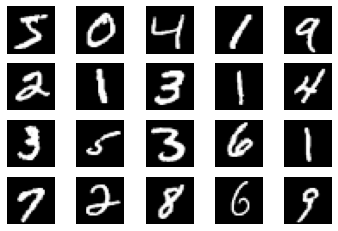

In [3]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("..")
from utils import *
from linear_regression import *
from svm import *
from softmax import *
from features import *
from kernel import *

#######################################################################
# 1. Introduction
#######################################################################

# Load MNIST data:
train_x, train_y, test_x, test_y = get_MNIST_data()
# Plot the first 20 images of the training set.
plot_images(train_x[0:20, :])

In [40]:
def closed_form(X, Y, lambda_factor):
    """
    Computes the closed form solution of linear regression with L2 regularization

    Args:
        X - (n, d + 1) NumPy array (n datapoints each with d features plus the bias feature in the first dimension)
        Y - (n, ) NumPy array containing the labels (a number from 0-9) for each
            data point
        lambda_factor - the regularization constant (scalar)
    Returns:
        theta - (d + 1, ) NumPy array containing the weights of linear regression. Note that theta[0]
        represents the y-axis intercept of the model and therefore X[0] = 1
    """
    X_transp = np.transpose(X)
    I = np.identity(len(X[0]))
    thethas = np.matmul(np.matmul(np.linalg.inv(np.matmul(X_transp, X)+lambda_factor*I),X_transp),Y)
    # θ=(XT*X+λ*I)−1*XT*Y 
    return(thethas)
    
    raise NotImplementedError

In [41]:
X = np.arange(1, 16).reshape(3, 5)
Y = np.arange(1, 4)
lambda_factor = 0.5

In [42]:
closed_form(X, Y, lambda_factor)

array([-0.03411225,  0.00320187,  0.04051599,  0.07783012,  0.11514424])

In [45]:
def run_linear_regression_on_MNIST(lambda_factor=1):
    """
    Trains linear regression, classifies test data, computes test error on test set

    Returns:
        Final test error
    """
    train_x, train_y, test_x, test_y = get_MNIST_data()
    train_x_bias = np.hstack([np.ones([train_x.shape[0], 1]), train_x])
    test_x_bias = np.hstack([np.ones([test_x.shape[0], 1]), test_x])
    theta = closed_form(train_x_bias, train_y, lambda_factor)
    test_error = compute_test_error_linear(test_x_bias, test_y, theta)
    
    return test_error


# Don't run this until the relevant functions in linear_regression.py have been fully implemented.
print('Linear Regression test_error =', run_linear_regression_on_MNIST(lambda_factor=0.01))

Linear Regression test_error = 0.7702


## Support Vector Machine

In [46]:
from sklearn.svm import LinearSVC

In [47]:
def one_vs_rest_svm(train_x, train_y, test_x):
    """
    Trains a linear SVM for binary classifciation

    Args:
        train_x - (n, d) NumPy array (n datapoints each with d features)
        train_y - (n, ) NumPy array containing the labels (0 or 1) for each training data point
        test_x - (m, d) NumPy array (m datapoints each with d features)
    Returns:
        pred_test_y - (m,) NumPy array containing the labels (0 or 1) for each test data point
    """
    
    clf = LinearSVC(C=0.1, random_state=0)
    clf.fit(train_x, train_y)
    pred_test_y = clf.predict(test_x)
    
    return(pred_test_y)


    raise NotImplementedError

In [49]:
def run_svm_one_vs_rest_on_MNIST():
    """
    Trains svm, classifies test data, computes test error on test set

    Returns:
        Test error for the binary svm
    """
    train_x, train_y, test_x, test_y = get_MNIST_data()
    train_y[train_y != 0] = 1
    test_y[test_y != 0] = 1
    pred_test_y = one_vs_rest_svm(train_x, train_y, test_x)
    test_error = compute_test_error_svm(test_y, pred_test_y)
    return test_error

print('SVM one vs. rest test_error:', run_svm_one_vs_rest_on_MNIST())


SVM one vs. rest test_error: 0.007499999999999951


In [53]:
def multi_class_svm(train_x, train_y, test_x):
    """
    Trains a linear SVM for multiclass classifciation using a one-vs-rest strategy

    Args:
        train_x - (n, d) NumPy array (n datapoints each with d features)
        train_y - (n, ) NumPy array containing the labels (int) for each training data point
        test_x - (m, d) NumPy array (m datapoints each with d features)
    Returns:
        pred_test_y - (m,) NumPy array containing the labels (int) for each test data point
    """
    clf = LinearSVC(C=0.1, random_state=0, max_iter=100000)
    clf.fit(train_x, train_y)
    pred_test_y = clf.predict(test_x)
    
    return(pred_test_y)
    
    raise NotImplementedError

In [54]:
def run_multiclass_svm_on_MNIST():
    """
    Trains svm, classifies test data, computes test error on test set

    Returns:
        Test error for the binary svm
    """
    train_x, train_y, test_x, test_y = get_MNIST_data()
    pred_test_y = multi_class_svm(train_x, train_y, test_x)
    test_error = compute_test_error_svm(test_y, pred_test_y)
    return test_error


print('Multiclass SVM test_error:', run_multiclass_svm_on_MNIST())


Multiclass SVM test_error: 0.08189999999999997


## Multinomial (Softmax) Regression and Gradient Descent

In [118]:
def compute_probabilities(X, theta, temp_parameter):
    """
    Computes, for each datapoint X[i], the probability that X[i] is labeled as j
    for j = 0, 1, ..., k-1

    Args:
        X - (n, d) NumPy array (n datapoints each with d features)
        theta - (k, d) NumPy array, where row j represents the parameters of our model for label j
        temp_parameter - the temperature parameter of softmax function (scalar)
    Returns:
        H - (k, n) NumPy array, where each entry H[j][i] is the probability that X[i] is labeled as j
    """
    
    """ 
    initialize N to the number of datapoints
    initialize K to the number of classes (i.e. number of labels)
    initialize H as an array (N, K)  (later you will transpose this)
    for each n from 0 to N-1, do
            set aux to theta*X[n] / temp_parameter (note: this * is a matriz multiplication)
            set c to the maximum value of aux
            update aux to aux - c
            set the numerator to exp(aux)
            set the denominator the sum of numerator
            set H[n] to numerator/denominator
    return the transpose of H 
    
    """
    
    N = X.shape[0]
    K = theta.shape[0]
    H = np.zeros((N,K))
    denominator = 0
    
    for n in range(N):
        aux = np.matmul(theta,X[n])/temp_parameter
        c = max(aux)
        aux = aux - c
        numerator = np.exp(aux)
        denominator = np.sum(numerator)
        H[n] = numerator/denominator
    
    return(np.transpose(H))
    
    raise NotImplementedError


In [134]:
n, d, k = 3, 5, 7
X = np.arange(0, n * d).reshape(n, d)
print(X)
temp = 0.2
theta = np.arange(0, k * d).reshape(k, d)
compute_probabilities(X, theta, temp)

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]]


array([[0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [7.12457641e-218, 0.00000000e+000, 0.00000000e+000],
       [2.66919022e-109, 0.00000000e+000, 0.00000000e+000],
       [1.00000000e+000, 1.00000000e+000, 1.00000000e+000]])

In [182]:
def compute_cost_function(X, Y, theta, lambda_factor, temp_parameter):
    """
    Computes the total cost over every datapoint.

    Args:
        X - (n, d) NumPy array (n datapoints each with d features)
        Y - (n, ) NumPy array containing the labels (a number from 0-9) for each
            data point
        theta - (k, d) NumPy array, where row j represents the parameters of our
                model for label j
        lambda_factor - the regularization constant (scalar)
        temp_parameter - the temperature parameter of softmax function (scalar)

    Returns
        c - the cost value (scalar)
    """
    c = 0
    N = X.shape[0]
    K = theta.shape[0]
    D = theta.shape[1]
    comp_prob = compute_probabilities(X, theta, temp_parameter)
    loss1 = 0
    loss2 = 0

    for i in range(N):
        j = Y[i]
        loss1 = loss1 + np.log(comp_prob[j,i])
    loss1 = loss1/N
    
    for j in range(K):
        for i in range(D):
            loss2 = loss2 + theta[j,i]**2
    loss2 = loss2*lambda_factor/2
    
    c = -loss1+loss2
    
    return(c)

    raise NotImplementedError

In [183]:
n, d, k = 3, 5, 7
X = np.arange(0, n * d).reshape(n, d)
Y = np.arange(0, n)
zeros = np.zeros((k, d))
temp = 0.2
lambda_factor = 0.5

print(zeros)
X.shape[0]

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


3

## Gradient Descent

In [188]:
def run_gradient_descent_iteration(X, Y, theta, alpha, lambda_factor, temp_parameter):
    """
    Runs one step of batch gradient descent

    Args:
        X - (n, d) NumPy array (n datapoints each with d features)
        Y - (n, ) NumPy array containing the labels (a number from 0-9) for each
            data point
        theta - (k, d) NumPy array, where row j represents the parameters of our
                model for label j
        alpha - the learning rate (scalar)
        lambda_factor - the regularization constant (scalar)
        temp_parameter - the temperature parameter of softmax function (scalar)

    Returns:
        theta - (k, d) NumPy array that is the final value of parameters theta
    """
    
    itemp=1./temp_parameter
    num_examples = X.shape[0]
    num_labels = theta.shape[0]
    probabilities = compute_probabilities(X, theta, temp_parameter)
    # M[i][j] = 1 if y^(j) = i and 0 otherwise.
    M = sparse.coo_matrix(([1]*num_examples, (Y,range(num_examples))), shape=(num_labels,num_examples)).toarray()
    non_regularized_gradient = np.dot(M-probabilities, X)
    non_regularized_gradient *= -itemp/num_examples
    return theta - alpha * (non_regularized_gradient + lambda_factor * theta)
    
    raise NotImplementedError

In [ ]:
def update_y(train_y, test_y):
    """
    Changes the old digit labels for the training and test set for the new (mod 3)
    labels.

    Args:
        train_y - (n, ) NumPy array containing the labels (a number between 0-9)
                 for each datapoint in the training set
        test_y - (n, ) NumPy array containing the labels (a number between 0-9)
                for each datapoint in the test set

    Returns:
        train_y_mod3 - (n, ) NumPy array containing the new labels (a number between 0-2)
                     for each datapoint in the training set
        test_y_mod3 - (n, ) NumPy array containing the new labels (a number between 0-2)
                    for each datapoint in the test set
    """
    
    for i in range(len(train_y)):
        train_y[i] = train_y[i]%3
    for j in range(len(test_y)):
        test_y[j] = test_y[j]%3
    return(train_y, test_y)

    raise NotImplementedError

In [ ]:
def compute_test_error_mod3(X, Y, theta, temp_parameter):
    """
    Returns the error of these new labels when the classifier predicts the digit. (mod 3)

    Args:
        X - (n, d - 1) NumPy array (n datapoints each with d - 1 features)
        Y - (n, ) NumPy array containing the labels (a number from 0-2) for each
            data point
        theta - (k, d) NumPy array, where row j represents the parameters of our
                model for label j
        temp_parameter - the temperature parameter of softmax function (scalar)

    Returns:
        test_error - the error rate of the classifier (scalar)
    """
    
    Y_est = get_classification(X, theta, temp_parameter)
    Y_est_mod3 = Y_est
    
    for i in range(len(Y_est)):
        Y_est_mod3[i] = Y_est[i]%3
    
    M = 0
    N = len(Y)
    for j in range(len(Y)):
        if Y_est_mod3[j] == Y[j]:
            M = M + 1
    
    test_error = np.around((N-M)/N, decimals=2)
    return(test_error)
    
    raise NotImplementedError


## Dimensionality Reduction Using PCA

In [230]:
def project_onto_PC(X, pcs, n_components, feature_means):
    """
    Given principal component vectors pcs = principal_components(X)
    this function returns a new data array in which each sample in X
    has been projected onto the first n_components principcal components.
    """
    # TODO: first center data using the feature_means
    # TODO: Return the projection of the centered dataset
    #       on the first n_components principal components.
    #       This should be an array with dimensions: n x n_components.
    # Hint: these principal components = first n_components columns
    #       of the eigenvectors returned by principal_components().
    #       Note that each eigenvector is already be a unit-vector,
    #       so the projection may be done using matrix multiplication.
    
    X_centred = X - feature_means
    pcs_local = pcs[0:pcs.shape[0], 0:n_components]
    projection = np.matmul(X_centred, pcs_local)
    
    return(projection)
    
    raise NotImplementedError


## Implementing Polynomial Kernel

In [245]:
def polynomial_kernel(X, Y, c, p):
    """
        Compute the polynomial kernel between two matrices X and Y::
            K(x, y) = (<x, y> + c)^p
        for each pair of rows x in X and y in Y.

        Args:
            X - (n, d) NumPy array (n datapoints each with d features)
            Y - (m, d) NumPy array (m datapoints each with d features)
            c - a coefficient to trade off high-order and low-order terms (scalar)
            p - the degree of the polynomial kernel

        Returns:
            kernel_matrix - (n, m) Numpy array containing the kernel matrix
    """
    n = X.shape[0]
    m = Y.shape[0]
    kernel_matrix = np.zeros((n,m))
    for i in range(n):
        for j in range(m):
            kernel_matrix[i,j] = (X[i] @ Y[j] + c) ** p
    
    return(kernel_matrix)

    raise NotImplementedError

In [246]:
def rbf_kernel(X, Y, gamma):
    """
        Compute the Gaussian RBF kernel between two matrices X and Y::
            K(x, y) = exp(-gamma ||x-y||^2)
        for each pair of rows x in X and y in Y.

        Args:
            X - (n, d) NumPy array (n datapoints each with d features)
            Y - (m, d) NumPy array (m datapoints each with d features)
            gamma - the gamma parameter of gaussian function (scalar)

        Returns:
            kernel_matrix - (n, m) Numpy array containing the kernel matrix
    """
    n = X.shape[0]
    m = Y.shape[0]
    kernel_matrix = np.zeros((n,m))
    for i in range(n):
        for j in range(m):
            kernel_matrix[i,j] = np.exp(-gamma * (np.linalg.norm(X[i] - Y[j]) ** 2))
    
    return(kernel_matrix)
    
    raise NotImplementedError